~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Fine-tune MedGemma with Hugging Face

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fmedgemma%2Fmain%2Fnotebooks%2Ffine_tune_with_hugging_face.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates fine-tuning MedGemma on an image and text dataset for a vision task using Hugging Face libraries.

In this guide, you will use Hugging Face's [Transformer Reinforcement Learning (`TRL`)](https://github.com/huggingface/trl) library to train the model with Supervised Fine-Tuning (SFT), utilizing [Quantized Low-Rank Adaptation (QLoRA)](https://arxiv.org/abs/2305.14314) to reduce computational costs while maintaining high performance.


## Setup

To complete this tutorial, you'll need to have a runtime with sufficient resources to fine-tune the MedGemma model. **Note:** This guide requires a GPU that supports bfloat16 data type and has at least 40 GB of memory.

You can run this notebook in Google Colab using an A100 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **A100 GPU**.

### Get access to MedGemma

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-4b-it) and accept the usage conditions.

### Configure your HF token

Generate a Hugging Face `write` access token by going to [settings](https://huggingface.co/settings/tokens). **Note:** Make sure that the token has write access to push the fine-tuned model to Hugging Face Hub.

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [ ]:
import os
import sys

if "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT"):
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

### Install dependencies

In [1]:
! pip install --upgrade --quiet bitsandbytes datasets evaluate peft tensorboard transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

## Prepare fine-tuning dataset

This notebook uses the [CBIS-DDSM](https://zenodo.org/records/1214456) dataset, containing images of mammogram containing  patches from histological images of human colorectal cancer (CRC) and normal tissue, to fine-tune MedGemma to classify tissue types.

**Note:** The full NCT-CRC-HE-100K dataset contains 100K samples. By default this guide only uses a subset with 10,000 samples to keep the training example small, but you can adjust this number if you want to experiment.

**Dataset citation:** Kather, J. N., Halama, N., & Marx, A. (2018). 100,000 histological images of human colorectal cancer and healthy tissue (v0.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1214456

Download the dataset from kaggle. This step may take around 15 minutes to complete.


In [1]:
! pip install google.colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

! unzip cbis-ddsm-breast-cancer-image-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset
License(s): CC-BY-SA-3.0
100% 4.93G/4.95G [01:01<00:00, 42.3MB/s]
100% 4.95G/4.95G [01:02<00:00, 85.7MB/s]


In [7]:
! unzip cbis-ddsm-breast-cancer-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295326067813319071803507885093865003464/1-076.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/2-266.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/1-233.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/1-294.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/2-223.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/1-013.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/2-012.jpg  

In [8]:
import pandas as pd

In [11]:

pwd

'/content'

In [12]:
df_calc_train = pd.read_csv("./csv/calc_case_description_train_set.csv")

In [13]:
df_calc_train.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [19]:
import matplotlib.pyplot as plt


In [31]:
#https://www.kaggle.com/code/aruzhanimasheva/cbis-ddsm-breast-cancer-image-dataset-training
df_dicom = pd.read_csv('/content/csv/dicom_info.csv')
df_dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [32]:
df_dicom.columns

Index(['file_path', 'image_path', 'AccessionNumber', 'BitsAllocated',
       'BitsStored', 'BodyPartExamined', 'Columns', 'ContentDate',
       'ContentTime', 'ConversionType', 'HighBit', 'InstanceNumber',
       'LargestImagePixelValue', 'Laterality', 'Modality', 'PatientBirthDate',
       'PatientID', 'PatientName', 'PatientOrientation', 'PatientSex',
       'PhotometricInterpretation', 'PixelRepresentation',
       'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID',
       'SamplesPerPixel', 'SecondaryCaptureDeviceManufacturer',
       'SecondaryCaptureDeviceManufacturerModelName', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesNumber', 'SmallestImagePixelValue',
       'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID',
       'StudyTime'],
      dtype='object')

In [33]:

full_mammo[1]

'CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'

In [40]:
#full mammogram images
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path

imdir = '/content/'
full_mammo = full_mammo.replace('CBIS-DDSM/', imdir, regex=True)

In [41]:

full_mammo[1]

'/content/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'

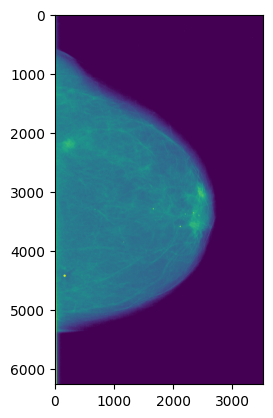

In [42]:

plt.imshow(plt.imread(full_mammo[1]))

In [47]:

df_dicom[df_dicom['image_path'].str.contains('1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132')][['StudyInstanceUID', 'SeriesInstanceUID']]

,StudyInstanceUID,SeriesInstanceUID
140,1.3.6.1.4.1.9590.100.1.2.346810468613236696616...,1.3.6.1.4.1.9590.100.1.2.100018879311824535125...
141,1.3.6.1.4.1.9590.100.1.2.346810468613236696616...,1.3.6.1.4.1.9590.100.1.2.100018879311824535125...


In [48]:
df_calc_train = pd.read_csv('/content/csv/calc_case_description_train_set.csv')

In [50]:

df_calc_train['image file path'][0]

'Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.408909860712120272633130274602115723157/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/000000.dcm'

In [53]:
df_dicom[df_dicom['image_path'].str.contains('1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548')]

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
2360,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.47414...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.474143...,NaN,16,16,BREAST,2761,20160503,105435.478,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.474143160103683865197...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.408909860712120272633...,161037.0


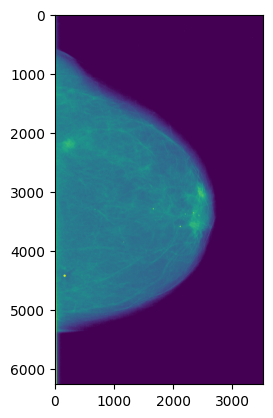

In [25]:


plt.imshow(plt.imread('/content/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'))

In [18]:
df_calc_train['ROI mask file path'][0]

'Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.328778919012412769218080124214088709081/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/000000.dcm'

In [15]:
df_calc_train[df_calc_train['image file path'].str.contains("1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132")]

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path


Load the data using the Hugging Face `datasets` library. Then, create train and validation splits.

In [ ]:
from datasets import load_dataset

train_size = 9000  # @param {type: "number"}
validation_size = 1000  # @param {type: "number"}

data = load_dataset("./NCT-CRC-HE-100K", split="train")
data = data.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=42,
)
# Use the test split as the validation set
data["validation"] = data.pop("test")

# Display dataset details
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label`: integer class label corresponding to tissue type

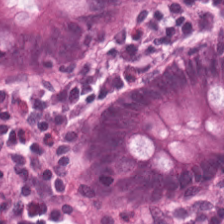

In [ ]:
data["train"][0]["image"]

In [ ]:
data["train"][0]["label"]

6

For this classification task, create a multiple-choice question prompt and preprocess the data into a multimodal conversational format.

In [ ]:
from typing import Any

TISSUE_CLASSES = [
    "A: adipose",
    "B: background",
    "C: debris",
    "D: lymphocytes",
    "E: mucus",
    "F: smooth muscle",
    "G: normal colon mucosa",
    "H: cancer-associated stroma",
    "I: colorectal adenocarcinoma epithelium"
]

options = "\n".join(TISSUE_CLASSES)
PROMPT = f"What is the most likely tissue type shown in the histopathology image?\n{options}"


def format_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": TISSUE_CLASSES[example["label"]],
                },
            ],
        },
    ]
    return example

Apply the processing function on the dataset.

In [ ]:
data = data.map(format_data)

# Display a processed data sample
data["train"][0]

{'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'label': 6,
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'What is the most likely tissue type shown in the histopathology image?\nA: adipose\nB: background\nC: debris\nD: lymphocytes\nE: mucus\nF: smooth muscle\nG: normal colon mucosa\nH: cancer-associated stroma\nI: colorectal adenocarcinoma epithelium',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'G: normal colon mucosa', 'type': 'text'}],
   'role': 'assistant'}]}

## Fine-tune the model with LoRA

Traditional fine-tuning of large language models is resource-intensive because it requires adjusting billions of parameters. Parameter-Efficient Fine-Tuning (PEFT) addresses this by training a smaller number of parameters. A common PEFT technique is Low-Rank Adaptation (LoRA), which efficiently adapts large language models by training small, low-rank matrices that are added to the original model instead of updating the full-weight matrices. In QLoRA, the base model is quantized to 4-bit before its weights are frozen, then LoRA adapter layers are attached and trained.

This notebook demonstrates supervised fine-tuning MedGemma with QLoRA using the `SFTTrainer` from the Hugging Face `TRL` library.

### Load model from Hugging Face Hub

Initialize the quantization configuration and load the model.

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

### Set up for fine-tuning

Create a [`LoraConfig`](https://huggingface.co/docs/peft/package_reference/lora#peft.LoraConfig). It will be provided to the `SFTTrainer`, which supports built-in integration with the Hugging Face `PEFT` library.

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Define a custom data collator that processes examples containing text and images and returns batches of data in the expected model input format.

In [ ]:
from typing import Any


def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []
    for example in examples:
        images.append([example["image"].convert("RGB")])
        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

Configure training parameters in an [`SFTConfig`](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

In [ ]:
from trl import SFTConfig

num_train_epochs = 1  # @param {type: "number"}
learning_rate = 2e-4  # @param {type: "number"}

args = SFTConfig(
    output_dir="medgemma-4b-it-sft-lora-crc100k",            # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,                       # Number of training epochs
    per_device_train_batch_size=4,                           # Batch size per device during training
    per_device_eval_batch_size=4,                            # Batch size per device during evaluation
    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=50,                                        # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=50,                                           # Number of steps between evaluations
    learning_rate=learning_rate,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
    push_to_hub=True,                                        # Push model to Hub
    report_to="tensorboard",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

### Fine-tune the model

Construct an [`SFTTrainer`](https://huggingface.co/docs/trl/sft_trainer) using the previously defined LoRA configuration, custom data collator, and training parameters.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(200)),  # Use subset of validation set for faster run
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

Launch the fine-tuning process.

**Note**: This may take around 3 hours to run using the default configuration.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
50,4.520300,0.032325
100,0.103300,0.026194
150,0.093900,0.021495
200,0.088900,0.022999
250,0.085500,0.021236
300,0.082200,0.020522
350,0.083400,0.020533
400,0.081500,0.019521
450,0.079800,0.019584
500,0.078200,0.019550


TrainOutput(global_step=562, training_loss=0.4797590243434567, metrics={'train_runtime': 10581.2693, 'train_samples_per_second': 0.851, 'train_steps_per_second': 0.053, 'total_flos': 7.820988839186266e+16, 'train_loss': 0.4797590243434567})

Save the final model to Hugging Face Hub.

In [ ]:
trainer.save_model()

Free up memory before proceeding to evaluate and test the fine-tuned model.

In [ ]:
del model
del trainer
torch.cuda.empty_cache()

## Evaluate the fine-tuned model

### Prepare test dataset

The [CRC-VAL-HE-7K](https://zenodo.org/records/1214456) dataset contains image patches from patients with colorectal adenocarcinoma and does not overlap with NCT-CRC-HE-100K. It can be used as the test dataset to evaluate the fine-tuned MedGemma model.

**Note:** The full CRC-VAL-HE-7K dataset contains over 7K samples. By default this guide only uses a subset with 1,000 samples to keep the evaluation example small.

Download and prepare the test dataset.

In [ ]:
! wget -nc -q "https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip"
! unzip -q CRC-VAL-HE-7K.zip

In [ ]:
from typing import Any

from datasets import load_dataset


def format_test_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
    ]
    return example


test_data = load_dataset("./CRC-VAL-HE-7K", split="train")
test_data = test_data.shuffle(seed=42).select(range(1000))
test_data = test_data.map(format_test_data)

### Set up for evaluation

Load the accuracy and F1 score metrics to evaluate the model's performance on the classfication task.

In [ ]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Ground-truth labels
REFERENCES = test_data["label"]


def compute_metrics(predictions: list[int]) -> dict[str, float]:
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=predictions,
        references=REFERENCES,
    ))
    metrics.update(f1_metric.compute(
        predictions=predictions,
        references=REFERENCES,
        average="weighted",
    ))
    return metrics

Define a postprocessing function to convert responses to integer class labels before computing metrics.

In [ ]:
from datasets import ClassLabel

# Rename the class names to the tissue classes, `X: tissue type`
test_data = test_data.cast_column(
    "label",
    ClassLabel(names=TISSUE_CLASSES)
)

LABEL_FEATURE = test_data.features["label"]
# Mapping to alternative label format, `(X) tissue type`
ALT_LABELS = dict([
    (label, f"({label.replace(': ', ') ')}") for label in TISSUE_CLASSES
])


def postprocess(prediction: list[dict[str, str]], do_full_match: bool=False) -> int:
    response_text = prediction[0]["generated_text"]
    if do_full_match:
        return LABEL_FEATURE.str2int(response_text)
    for label in TISSUE_CLASSES:
        # Search for `X: tissue type` or `(X) tissue type` in the response
        if label in response_text or ALT_LABELS[label] in response_text:
            return LABEL_FEATURE.str2int(label)
    return -1

### Compute baseline metrics on the pretrained model

Load the pretrained model using the `pipeline` API.

In [ ]:
from transformers import pipeline

pt_pipe = pipeline(
    "image-text-to-text",
    model=model_id,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Run batch inference on the test dataset.

In [ ]:
pt_outputs = pt_pipe(
    text=test_data["messages"],
    images=test_data["image"],
    max_new_tokens=40,
    batch_size=64,
    return_full_text=False,
)

pt_predictions = [postprocess(out) for out in pt_outputs]

Compute metrics.

In [ ]:
pt_metrics = compute_metrics(pt_predictions)
print(f"Baseline metrics: {pt_metrics}")

Baseline metrics: {'accuracy': 0.43, 'f1': 0.3520150005688922}


### Compute metrics on the fine-tuned model

Load the base model with the fine-tuned LoRA adapter using the `pipeline` API.

In [ ]:
ft_pipe = pipeline(
    "image-text-to-text",
    model=args.output_dir,
    processor=processor,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
# Use left padding during inference
processor.tokenizer.padding_side = "left"

Run batch inference on the test dataset.

In [ ]:
ft_outputs = ft_pipe(
    text=test_data["messages"],
    images=test_data["image"],
    max_new_tokens=20,
    batch_size=64,
    return_full_text=False,
)

ft_predictions = [postprocess(out, do_full_match=True) for out in ft_outputs]

Compute metrics.

In [ ]:
ft_metrics = compute_metrics(ft_predictions)
print(f"Fine-tuned metrics: {ft_metrics}")

Fine-tuned metrics: {'accuracy': 0.945, 'f1': 0.9440669568493043}


# Next steps

Explore the other [notebooks](https://github.com/google-health/medgemma/blob/main/notebooks) to learn what else you can do with the model.